In [2]:
# ============================================================
# 02_baseline_model.ipynb
# Construction et entraînement du modèle baseline InceptionV3
# ============================================================

# ------------------------------------------------------------
# 1. Importations
# ------------------------------------------------------------
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


In [3]:
# ------------------------------------------------------------
# 2. Définition des chemins
# ------------------------------------------------------------
DATASET_PATH = "../data/flower_images"
MODEL_DIR = "../models"

# Création du dossier modèles si inexistant
os.makedirs(MODEL_DIR, exist_ok=True)

if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset introuvable : {DATASET_PATH}")

print("Chemin dataset :", DATASET_PATH)
print("Classes détectées :", os.listdir(DATASET_PATH))


Chemin dataset : ../data/flower_images
Classes détectées : ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']


In [4]:
# ------------------------------------------------------------
# 3. Paramètres et hyperparamètres
# ------------------------------------------------------------
IMG_SIZE = (299, 299)
BATCH_SIZE = 32
EPOCHS = 15       # Baseline : petit entraînement pour test
LR = 0.0001


In [5]:
# ------------------------------------------------------------
# 4. Générateurs de données (avec augmentation)
# ------------------------------------------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,  # 20% des images pour validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [6]:
# ------------------------------------------------------------
# 5. Chargement du modèle InceptionV3 pré-entraîné
# ------------------------------------------------------------
base_model = InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

base_model.trainable = False  # On gèle toutes les couches pour le baseline


In [6]:
# ------------------------------------------------------------
# 6. Construction du modèle final
# ------------------------------------------------------------
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)  # Régularisation
outputs = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 299, 299, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 149, 149, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 149, 149, 32)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 149, 149, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 147, 147, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 147, 147, 32)      │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 147, 147, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 147, 147, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 147, 147, 64)      │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 147, 147, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 73, 73, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 73, 73, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 73, 73, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 73, 73, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 71, 71, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 21,813,029 (83.21 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [7]:
# ------------------------------------------------------------
# 7. Compilation du modèle
# ------------------------------------------------------------
model.compile(
    optimizer=Adam(learning_rate=LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [8]:
# ------------------------------------------------------------
# 8. Entraînement du modèle
# ------------------------------------------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


C:\Users\pc\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 516s 4s/step - accuracy: 0.2948 - loss: 1.6116 - val_accuracy: 0.5080 - val_loss: 1.3274
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 492s 4s/step - accuracy: 0.4655 - loss: 1.3131 - val_accuracy: 0.6320 - val_loss: 1.1050
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 491s 4s/step - accuracy: 0.5798 - loss: 1.1203 - val_accuracy: 0.6940 - val_loss: 0.9624
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 491s 4s/step - accuracy: 0.6093 - loss: 1.0205 - val_accuracy: 0.7260 - val_loss: 0.8740
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 490s 4s/step - accuracy: 0.6587 - loss: 0.9347 - val_accuracy: 0.7520 - val_loss: 0.8073
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 492s 4s/step - accuracy: 0.6840 - loss: 0.8819 - val_accuracy: 0.7970 - val_loss: 0.7398
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 492s 4s/step - accuracy: 0.7120 - loss: 0.8135 - val_accuracy: 0.7880 - val_loss: 0.7091
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 492s 4s/step - accuracy: 0.7285 - loss: 0.7765 - val_accu

In [9]:
# ------------------------------------------------------------
# 9. Sauvegarde du modèle baseline
# ------------------------------------------------------------
BASELINE_MODEL_PATH = os.path.join(MODEL_DIR, "inception_baseline.h5")
model.save(BASELINE_MODEL_PATH)
print("Modèle baseline sauvegardé →", BASELINE_MODEL_PATH)


Modèle baseline sauvegardé → ../models\inception_baseline.h5


In [10]:
# ------------------------------------------------------------
# 10. Sauvegarde de l'historique pour évaluation
# ------------------------------------------------------------
HISTORY_PATH = os.path.join(MODEL_DIR, "history_baseline.pkl")
with open(HISTORY_PATH, "wb") as f:
    pickle.dump(history.history, f)

print("Historique sauvegardé →", HISTORY_PATH)


Historique sauvegardé → ../models\history_baseline.pkl


Modèle baseline chargé : ../models/inception_baseline.h5
Historique chargé : ../models/history_baseline.pkl
32/32 ━━━━━━━━━━━━━━━━━━━━ 151s 5s/step

📊 Rapport de classification (Baseline) :

              precision    recall  f1-score   support

       Lilly       0.78      0.78      0.78       200
       Lotus       0.79      0.84      0.82       200
      Orchid       0.81      0.83      0.82       200
   Sunflower       0.93      0.94      0.94       200
       Tulip       0.90      0.79      0.84       200

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



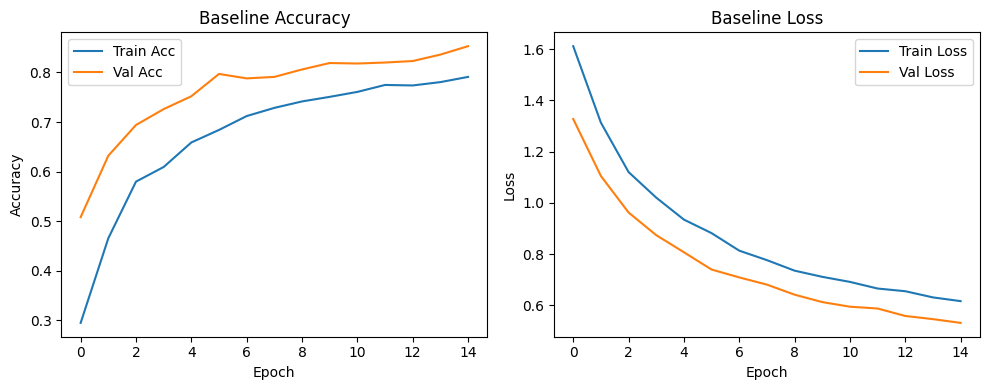

In [9]:
# ------------------------------------------------------------
# 11. Recharger le modèle et l'historique pour affichage
# ------------------------------------------------------------

# Chemins des fichiers
MODEL_PATH = "../models/inception_baseline.h5"
HISTORY_PATH = "../models/history_baseline.pkl"

# 1. Recharger le modèle
model = tf.keras.models.load_model(MODEL_PATH)
print("Modèle baseline chargé :", MODEL_PATH)

# 2. Recharger l'historique
with open(HISTORY_PATH, "rb") as f:
    history = pickle.load(f)
print("Historique chargé :", HISTORY_PATH)

# 3. Classes
class_names = list(val_gen.class_indices.keys())

# 4. Prédictions sur l'ensemble de validation
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# 5. Rapport de classification
report = classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names
)
print("\n📊 Rapport de classification (Baseline) :\n")
print(report)

# 6. Affichage des courbes Accuracy & Loss
plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Train Acc')
plt.plot(history['val_accuracy'], label='Val Acc')
plt.title("Baseline Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title("Baseline Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
